# Analysis of time-to-resolve Get It Done San Diego requests
## Notebook 1: Basic import and cleaning
This notebook details import and cleaning of data from the City of San Diego's Get It Done app. The Get It Done App is similar to other 311 services in that it enables San Diego residents to report problems to the city; in this case residents can report via phone app, website, or phone call. The Get It Done database contains all of the reports filed since the app's launch in May 2016.

The overall goal of this analysis is to determine whether there are any identifiable patterns in the amount of time it takes to resolve an individual issue. To this end, demographic information from the 2010 Census is incorporated into the dataset. This information is available at the zipcode level, and will be matched to the zipcode associated with each individual Get It Done request.

NOTE ABOUT DATA AND RUNTIME: Zipped versions of the .csv files used in this notebook can be found in the /data subdirectory. Some of these cells take a very long time to run (it takes about 3-4 hours to run this entire notebook), so please look for warnings in the description above each cell before deciding to run it. If you just want to mess around with the dataframes after the different processing stages below, you can load either 'gid_with_zipcodes.csv', 'gid_with_zip_load.csv' or 'gid_with_demo.csv'

### Load all necessary libraries

In [1]:
import glob
import pandas as pd
from datetime import timedelta
import numpy as np
from uszipcode import Zipcode, SearchEngine
import matplotlib.pyplot as plt

### Import and append original CSV files, remove duplicate requests
As of 11/17/2018, the San Diego Open Data Portal has made several large revisions to this data

* Instead of one continually overwritten csv file, it is now broken up by year, so there are separate files for 2016, 2017, and 2018(YTD)
* Many of the columns have been dropped: The original dataset had 38 columns; the version in 9/11/2018 had 29 (the 'question' and 'answer' columns were dropped); the current version is down to 12 columns. Some of the previous columns have been merged into single fields
* Information about duplicate requests has been dropped

So a little extra processing is needed to remove duplicate requests where possible:
1. Extract duplicate request information from old dataset
2. Load and concatenate updated versions of datasets
3. Join the full dataset with the dataframe containing duplicate information; drop columns that track duplicate information
4. Also, remove cancelled requests

In [2]:
# Load and concatenate updated versions of datasets
gid_df = pd.concat([pd.read_csv(f,
                               parse_dates=['requested_datetime','updated_datetime'],
                               usecols=['service_request_id','requested_datetime','service_name',
                                        'case_record_type','updated_datetime','status',
                                        'lat','long','district','case_origin']) 
                    for f in glob.glob('data/get_it_done_201*.csv')], ignore_index = True)

# Drop rows with NaN values
gid_df = gid_df.dropna(axis=0, how='any', subset=['service_request_id','requested_datetime',
                                        'service_name','case_record_type',
                                        'status','lat','long','district','case_origin'])

# Change district from float to integer (it's a categorical variable, not a number)
gid_df.district = gid_df.district.astype(int, copy=False)

# Extract duplicate request information from old dataset
gid_duplicates = pd.read_csv('data/OLD_get_it_done_311_requests_datasd_20180729.csv',
                               usecols=['service_request_id',
                                        'parent_case_number','duplicate_verified'])

# drop any rows if there are NaN values in service_request_id
gid_duplicates = gid_duplicates.dropna(axis=0, how='any', subset=['service_request_id'])

# If request has a parent id, change duplicate_verified to 1
gid_duplicates.loc[(gid_duplicates.parent_case_number > 0), 'duplicate_verified'] = 1

# Drop rows if any column *except* 'updated_datetime' has a NaN
gid_df = gid_df.dropna(axis=0, how='any', subset=['service_request_id','requested_datetime',
                                        'service_name','case_record_type',
                                        'status','lat','long','district','case_origin'])

# Join the two dataframes on service_request_id (unique identifier)
gid_df = pd.merge(gid_df, gid_duplicates, on='service_request_id', how='left')

# Drop records that are tagged as duplicates (from older dataset)
gid_df = gid_df[gid_df.duplicate_verified != 1]

# Drop records that are tagged as duplicates (in newer dataset)
gid_df = gid_df[gid_df.status != 'Duplicate']

# Drop the 'parent_case_number' and 'duplicate_verified' columns because
# we no longer need them
gid_df = gid_df.drop(['parent_case_number', 'duplicate_verified'], axis=1)

# remove 'cancelled' requests (there are only 62 of these, and this is no longer included in 
# the 'status' field as of 1/1/2019)
gid_df = gid_df[gid_df['status'] != 'Cancelled']

### Combine or remove some service_names
Some service_name categories are clearly mistakes and should be combined or removed altogether--such as 'STREET LIGHT LIGHT ON DURING DAY' and 'STREET LIGHT ON DURING DAY' or '--SELECT ANSWER--'

In [3]:
# Change all service_name labels to all UPPERCASE
gid_df['service_name'] = gid_df['service_name'].str.upper()

# SERVICE_NAME FIXES
# remove '--SELECT ANSWER--'
gid_df = gid_df[gid_df['service_name'] != '--SELECT ANSWER--']

# combine 'STREET LIGHT' categories
gid_df.loc[(gid_df['service_name']=='STREET LIGHT STREET LIGHT OUT'),
           'service_name'] = 'STREET LIGHT OUT'

gid_df.loc[(gid_df['service_name']=='STREET LIGHT LIGHT ON DURING THE DAY') |
           (gid_df['service_name']=='STREET LIGHT LIGHT ON DURING DAY'),
           'service_name'] = 'STREET LIGHT ON DURING DAY'

# combine 'TRAFFIC SIGNAL' categories
gid_df.loc[(gid_df['service_name']=='TRAFFIC SIGNAL TRAFFIC SIGNAL-TRAFFIC SIGNAL'),
           'service_name'] = 'TRAFFIC SIGNAL OTHER PROBLEM'
gid_df.loc[(gid_df['service_name']=='TRAFFIC SIGNAL POLE KNOCK OVER/DAMAGE'),
           'service_name'] = 'TRAFFIC SIGNAL KNOCK OVER/DAMAGE'
gid_df.loc[(gid_df['service_name']=='TRAFFIC SIGNAL LIGHTS OUT'),
           'service_name'] = 'TRAFFIC SIGNAL LIGHT OUT'
gid_df.loc[(gid_df['service_name']=='TRAFFIC SIGNAL LIGHTS ON FLASH'),
           'service_name'] = 'TRAFFIC SIGNAL ON FLASH'

# convert Spanish-to-English
gid_df.loc[(gid_df['service_name']=='VIOLACIÓN 72 HORAS'),
           'service_name'] = '72 HOUR VIOLATION'

### Add columns to provide more information about how long it takes to resolve a request
The amount of time it takes to resolve a report will be the primary outcome measure of this analysis, so the 'requested_datetime' and 'closed_date' columns need to be transformed to more useful information.

1. Create a new timedelta variable that is the amount of time lapsed from opening a request to when the request was closed.
2. Convert those timedelta vaules into floats representing 'how many days' to close

An additional column ('resolved') is created to represent whether a request is resolved.

In [4]:
# create new column datetime_till_closed
gid_df['datetime_till_closed'] = gid_df['updated_datetime'] - gid_df['requested_datetime']

# create new floats column days_till_closed
gid_df['days_till_closed'] = gid_df['datetime_till_closed'] / timedelta (days=1)

# Add one column to track resolved vs unresolved, where 'resolved' = ['Closed - Referred', 'Closed', 'Referred']
# and 'unresolved' are all other requests
gid_df['resolved'] = 0
gid_df.loc[(gid_df['status'] == 'Closed') |
           (gid_df['status'] == 'Closed - Referred') |
           (gid_df['status'] == 'Referred'),
           'resolved'] = 1

### Add zipcode information to each request by converting latitude/longitude values
WARNING: This about 20 minutes to run! You can load 'data/gid_with_zipcodes.csv' to examine the dataframe after processing in this cell.

Residents have the option of entering an address along with their request, but don't always do so. Residents are also asked to mark the location of the problem on a map of the city, and the latitude/longitude values from that are stored along with the request; almost every request *does* include latitude/longitude values.

I used the uszipcode database and search engine (available at https://pypi.org/project/uszipcode/) to convert lat/long values to zipcodes for every request.

In [5]:
# first create zipcode lookup using uszipcode library
search = SearchEngine(simple_zipcode=True)

# next add zipcode column to dataframe
gid_df['zipcode'] = ''

# this function looks up zipcode for a single gid request
def lookup_zipcode(row):
    result = search.by_coordinates(row.lat, row.long, radius=1.0)
    if len(result) > 0:
        zip2 = result[0].zipcode
        return zip2

    # if we can't find a zipcode within a 1-mile radius, increase to 2-mile radius
    else:
        result = search.by_coordinates(row.lat, row.long, radius=2.0)
        if len(result) > 0:
            zip2 = result[0].zipcode
            return zip2
        
        # if 2-mile radius didn't work, increase to 3-mile radius
        else:
            result = search.by_coordinates(row.lat, row.long, radius=3.0)
            if len(result) > 0:
                zip2 = result[0].zipcode
                return zip2
            
            # if 3-mile radius didn't work, give up and return NaN
            else:
                return(np.nan)

gid_df.loc[:,['zipcode']] = gid_df.apply(lookup_zipcode, axis=1)

# Again, drop rows that have any NaN values 
gid_df = gid_df.dropna(axis=0, how='any', subset=['zipcode'])

# Verify that zipcodes are now added to the gid_requests dataframe
gid_df['zipcode'].head()

# Save progress so far
#gid_df.to_csv('data\gid_with_zipcodes.csv', header=True)

### Add columns to reflect service 'load'
WARNING: This section takes *hours* to run. You can load 'data/gid_with_zip_load.csv' to get the dataframe after processing in this cell.

The goal is to add some features that may help a model predict how long it takes to close a request. These two new features ('load_by_service' and 'load_by_service_zip') show how many open requests there are for that same type of request (e.g. 'STREET LIGHT OUT') when a new one is entered into the queue. 'load_by_service' is the number of open requests in that same category across the entire city; 'load_by_service_zip' is the number of open requests in that same category in the same zipcode as the new request. Code structure is as follows:
1. We need two sorted dataframes - one sorted by requested_datetime (the default), one sorted by updated_datetime (has to be filtered for status = 'Closed' only)
2. Then there is a big ugly loop section to figure out how many 'open' service requests there are for an individual request_id entry. We'll figure out both how many open service requests there are with the same service_name, and then how many with the same service_name AND in the same zipcode

In [6]:
# Add two new columns: load_by_service, load_by_service_zip
gid_df['load_by_service'] = 0
gid_df['load_by_service_zip'] = 0

# Create sorted dataframe
gid_closed_sorted = gid_df[gid_df['status']=='Closed'].sort_values(by='updated_datetime')

# Outer loop cycles through service_name
for service in gid_df.service_name.unique():
    # create df's for only that service_name
    service_df = gid_df[gid_df['service_name'] == service]
    service_closed_df = gid_closed_sorted[gid_closed_sorted['service_name'] == service]
    
    # inner loop cycles through individual request_id's
    for request in service_df.service_request_id:
        # find the row index, date, and zipcode of the request
        idx = service_df.loc[service_df['service_request_id']==request].index[0]
        current_date = service_df.loc[idx].requested_datetime
        current_zip = service_df.loc[idx].zipcode
        # how many requests have been made up to this point (total and in zipcode)
        all_requests = len(service_df[service_df['requested_datetime'] < current_date])
        all_requests_zip = len(service_df[(service_df['requested_datetime'] < current_date) &
                                      (service_df['zipcode'] == current_zip)])
        # how many of those requests are already closed?
        closed_requests = len(service_closed_df[service_closed_df['updated_datetime'] < current_date])
        closed_requests_zip = len(service_closed_df[(service_closed_df['updated_datetime'] < current_date) &
                                                (service_closed_df['zipcode'] == current_zip)])
        # fill in load_by_service and load_by_service_zip
        idx_master_df = gid_df.loc[gid_df['service_request_id'] == request].index[0]
        gid_df.loc[idx_master_df,'load_by_service'] = all_requests - closed_requests
        gid_df.loc[idx_master_df,'load_by_service_zip'] = all_requests_zip - closed_requests_zip
    
#gid_df.to_csv('data\gid_with_zip_load.csv', header=True)

### Import 2010 Census demographic information
The median household income, housing value, and age come from the SANDAG spreadsheet. Additional population density per square mile comes from [https://blog.splitwise.com/2014/01/06/free-us-population-density-and-unemployment-rate-by-zip-code/]. Both spreadsheets are coded by zipcode.

In [9]:
sandag_file = 'data/censusacs_2010_zip_all_2018_09_11 03_52.xlsx'
sandag_data = pd.ExcelFile(sandag_file)

# Parse and extract median household income
household_income = sandag_data.parse('Household Income', skiprows=1, names=['zipcode','year', 'measure', 'household_income'])
household_income['zipcode'] = household_income['zipcode'].astype(str)
household_income = household_income.set_index('zipcode')
household_income = household_income.loc[household_income['measure'] == 'median income']
household_income = household_income.loc[:,['household_income']]

# Parse and extract median housing value
housing_value = sandag_data.parse('Housing Value', skiprows=1, names=['zipcode','year', 'measure', 'housing_value'])
housing_value['zipcode'] = housing_value['zipcode'].astype(str)
housing_value = housing_value.set_index('zipcode')
housing_value = housing_value.loc[housing_value['measure'] == 'median value']
housing_value = housing_value.loc[:,['housing_value']]

# Parse and extract median age
age = sandag_data.parse('Age and Sex', skiprows=1, names=['zipcode','year','measure','median_age','age_male','age_female'])
age['zipcode'] = age['zipcode'].astype(str)
age = age.set_index('zipcode')
age = age.loc[age['measure'] == 'median']
age = age.drop(['age_male', 'age_female'], axis=1)

# Merge these three dataframes together
demographic_info = pd.merge(household_income, housing_value, on=['zipcode'], how='outer')
demographic_info = pd.merge(demographic_info, age, on=['zipcode'], how='outer')
demographic_info = demographic_info.drop(['year','measure'], axis=1)

# One more dataset (population density)!
pop_density = pd.read_csv('data/Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv', dtype={'Zip/ZCTA':str})
pop_density.rename(columns={'Zip/ZCTA': 'zipcode', 'Density Per Sq Mile': 'pop_density'}, inplace=True)
pop_density = pop_density.set_index('zipcode')

# Merge the final dataset
demographic_info = pd.merge(demographic_info, pop_density, on=['zipcode'], how='left')
demographic_info = demographic_info.drop(['2010 Population','Land-Sq-Mi'], axis=1)

#demographic_info.to_csv('Demographic_Info.csv')

This scatterplot (below) of median housing value vs. median household income is meant as a sanity check. The plot actually does indicate a potential problem with the data. The first housing value of 1.4 million seems improbable, given that is associated with a median annual income of less than $60K. Upon examing the original SANDAG spreadsheet more closely, it turns out that there are several zipcodes that should be excluded from further analysis:

* 92093 - University of California at San Diego
* 92134 - Balboa Park
* 92135 - Coronado Air Base and Naval Station
* 92145 - Miramar Air Base
* 92140 - Lindberg Field (the San Diego airport)
* 92155 - Silver Strand military housing

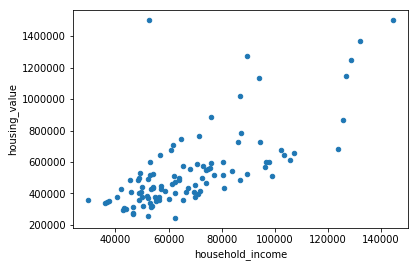

In [10]:
demographic_info.plot(kind='scatter', x='household_income', y='housing_value')
plt.show()

### Merge the gid_requests dataframe with the SANDAG demographic dataframe, remove unrepresentative zip codes
After merging, drop all requests from the outlier zipcodes listed above

In [11]:
gid_with_demo = pd.merge(gid_df, demographic_info, on=['zipcode'], how='left')

# Remove requests from 'odd' zipcodes
gid_with_demo = gid_with_demo[gid_with_demo.zipcode != '92093']
gid_with_demo = gid_with_demo[gid_with_demo.zipcode != '92134']
gid_with_demo = gid_with_demo[gid_with_demo.zipcode != '92135']
gid_with_demo = gid_with_demo[gid_with_demo.zipcode != '92145']
gid_with_demo = gid_with_demo[gid_with_demo.zipcode != '92140']
gid_with_demo = gid_with_demo[gid_with_demo.zipcode != '92155']

# save merged, cleaned dataframe to CSV file
#gid_with_demo.to_csv('data\gid_with_demo.csv', header=True)